<a href="https://colab.research.google.com/github/Abdelrahman26/FarmTopia-CV-Internship/blob/main/FarmTopia-CV-Internship/Anwar/stitching_and_PYM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy 
import imutils
import cv2 
import matplotlib.pyplot as plt

In [4]:
cv2.__version__

'3.4.2'

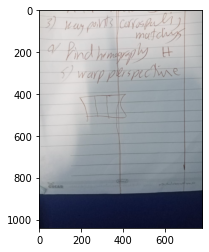

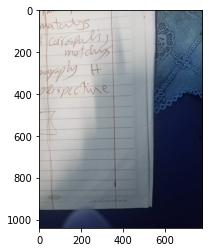


Result image


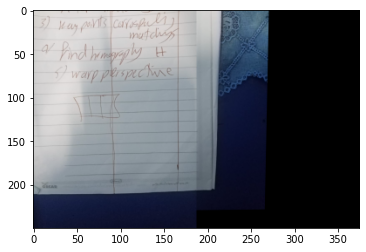

------------------------------------


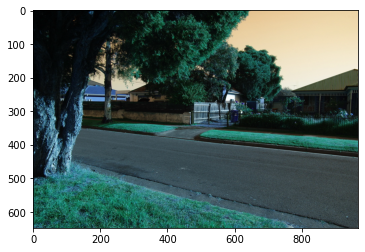

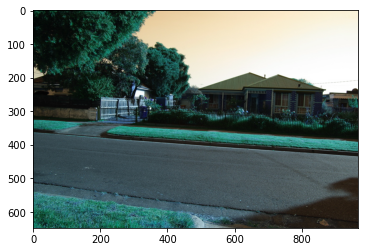

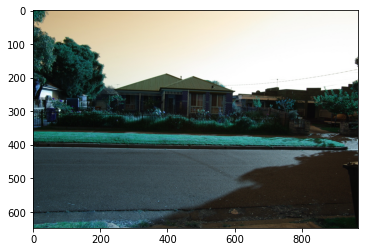

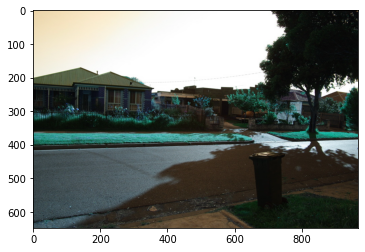




Result image


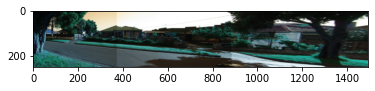

In [20]:

def readImages(imageString, plot = True):
	'''
	 input: list of images names
	 output: list of rgb images
	'''
	images = []
	# Get images from arguments.
	for i in range(0, len(imageString)):
		img = cv2.imread(imageString[i])
		images.append(img)
		if plot == True:
			plt.imshow(img)
		plt.show()

	return images

def findAndDescribeFeatures(image):
	'''
	Here, we find keypoints, features using SIFT or SURF
	input: image
	output: keypoints, features
	'''
	#Getting gray image
	grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

	#Find and describe the features.
	# Fast: sift = cv2.xfeatures2d.SURF_create()
	sift = cv2.xfeatures2d.SURF_create()

	#Find interest points.
	#keypoints = sift.detect(grayImage, None)

	#Computing features.
	keypoints, features = sift.detectAndCompute(grayImage, None)

	#Converting keypoints to numbers.
	keypoints = numpy.float32([kp.pt for kp in keypoints])


	return keypoints, features

def matchFeatures(featuresA, featuresB):
	'''
	Matching between two list of features using KNN 
	input: features of two images
	output: list of matches
	'''
	# Slow: featureMatcher = cv2.DescriptorMatcher_create("BruteForce")
	featureMatcher = cv2.DescriptorMatcher_create("FlannBased")
	matches = featureMatcher.knnMatch(featuresA,featuresB, k=2)
	return matches

def generateHomography(allMatches, keypointsA, keypointsB, ratio, ransacRep):
	'''
	Refinement matchs using Lowe's ratio test. Finding Homography between two list if keypoints
	input:allMatches, keypointsA, keypointsB, ratio, ransacRep
	output: refined matchs, H(transformation matrix) and status
	'''
	if not allMatches:
		return None
	matches = []

	for match in allMatches:
		# Lowe's ratio test
		if len(match) == 2 and (match[0].distance/match[1].distance) < ratio:
			matches.append(match[0])

	pointsA = numpy.float32([keypointsA[m.queryIdx] for m in matches])
	pointsB = numpy.float32([keypointsB[m.trainIdx] for m in matches])

	if len(pointsA)>4:
		H, status = cv2.findHomography(pointsA, pointsB, cv2.RANSAC,ransacRep)
		return matches, H, status
	else:
		return None

def Panorama (images):
	while len(images)>1:
		imgR = images.pop()
		imgL = images.pop()

		interestsR, featuresR = findAndDescribeFeatures(imgR)
		interestsL, featuresL = findAndDescribeFeatures(imgL)
		print()
		allMatches = matchFeatures(featuresR, featuresL)
		_, H, _ = generateHomography(allMatches, interestsR, interestsL, 0.75, 1.0)

		result = cv2.warpPerspective(imgR, H, 
			(imgR.shape[1]+imgL.shape[1], imgR.shape[0]))
		result[0:imgL.shape[0], 0:imgL.shape[1]] = imgL
		images.append(result)
		cv2.imwrite('Result'+str(len(images))+'.jpg',result)

	result = imutils.resize(images[0],height=250)
	print('Result image')
	plt.imshow(result)
	plt.show()

images = readImages(['1.jpeg' , '2.jpeg'])
Panorama(images)
print('------------------------------------')
images = readImages(['001.jpg' , '002.jpg','003.jpg','004.jpg'])
Panorama(images)

In [6]:
import numpy as np

rgb image


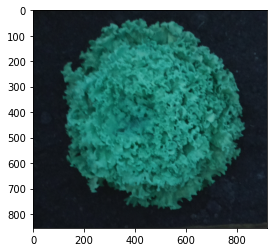

PYM image


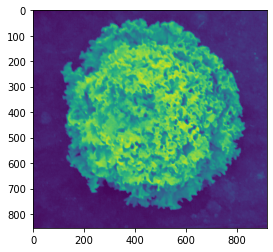

Segmentation image


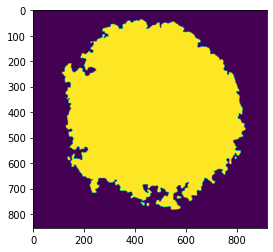

PYM_leaf_area_estimation :-  374112.5


In [11]:
def PYM_image_transformation(original): 
    "This function performs the PYM calculation and returns a new frame"
    h, w = original[:,:,0].shape # get original image shape
    pym = np.zeros((h, w),np.int) # blank b/w image for storing pym image
    red = np.zeros((h, w),np.int) # blank array for red
    blue = np.zeros((h, w),np.int) # blank array for blue

    # Specific channels
    red = (original[:,:,2]).astype('float') # reading red channel from original image (NIR)
    blue = (original[:,:,0]).astype('float') # reading blue channel from original image (blue)

    # PYM calculation
    max_sc = np.amax(red - blue/2)
    pym = ((red - blue/2)*255/max_sc).astype('uint8') # computing new channel
    
    pym[red - blue/2 < 0] = 0 # setting limit
    
    # False color image
    False_color_image = np.zeros((h, w,3),np.uint8) # make a blank RGB image 
    False_color_image[:,:,1] = pym
    False_color_image[:,:,2] = 255 - pym
   
    return pym  # return the image 


def PYM_leaf_area_estimation(img, include_holes=True, plot = True):
    image_source = cv2.imread(img) # import source image
    t = PYM_image_transformation(image_source) # Transform image with PYM_image_transformation function
    cv2.imwrite('pym.jpg', t) # saving image

    ret,thresh1 = cv2.threshold(t, 0, 255, cv2.THRESH_OTSU) # OTSU's thresholding
    kernel_open = np.ones((6,6),np.uint8) # large kernel
    kernel_mid = np.ones((4,4),np.uint8) # medium kernel
    kernel_close = np.ones((2,2),np.uint8) # small kernel
    kernel_veryclose = np.ones((1,1),np.uint8) # tiny petit

    erosion = cv2.erode(thresh1, kernel_veryclose,iterations = 1) # edge erosion
    opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel_open) # removing noise around the plant
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel_mid) # removing noise inside the plant
    #contours, hierarchy = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) # finding plant contours
    aa, contours, hierarchy = cv2.findContours(closing,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) # with an older version of opencv
  
    if include_holes==1: # Counting all pixels inside the largest area
        areas = [] # list
        for contour in contours:
            ar = cv2.contourArea(contour)
            areas.append(ar)
        sorted_area = sorted(areas, key=int, reverse = True)
        leaf_area = sorted_area[0] # largest area, plant area by definition
        leaf_area_index = areas.index(leaf_area) # finding area index 
        cnt = contours[leaf_area_index] # plant contours, with holes included
        cv2.drawContours(closing, [cnt], 0,(255,0,0),-1) # drawing contours with holes included
        
    if include_holes==0: # Counting all pixels detected 
        cv2.drawContours(closing, contours, -1, (255, 255, 255), -1) # drawing contours without including holes
        leaf_area = (closing > 127).sum() # couting plants pixels        

    cv2.imwrite('closing.jpg', closing) # Saving image
    if plot == True:
      print('rgb image')
      plt.imshow(image_source)
      plt.show()
      print('PYM image')
      plt.imshow(t)
      plt.show()
      print('Segmentation image')
      plt.imshow(closing)
      plt.show()
      
    return leaf_area # Plant area is returned as output of the function


t = PYM_leaf_area_estimation('Figure_3_A1.jpg')
print('PYM_leaf_area_estimation :- ',t)